<a href="https://colab.research.google.com/github/ivsu/university_public/blob/main/11%D0%B4%D0%B7_%D1%87%D0%B5%D1%80%D0%BD%D0%BE%D0%B2%D0%B8%D0%BA_%7C_%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%7C_%D0%94%D0%97_Ultra_Pro_%7C_%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

1. На основе учебного ноутбука, проведите финальную подготовку данных. измените количество сегментирующих классов с `16` на `7`
 - 0_класс - FLOOR
 - 1_класс - CEILING
 - 2_класс - WALL
 - 3_класс - APERTURE, DOOR, WINDOW 
 - 4_класс - COLUMN, RAILINGS, LADDER
 - 5_класс - INVENTORY
 - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

2. Реализуйте сегментацию базы Стройка на основе модели `PSPnet`. Статья для изучения [Pyramid Scene Parsing Network](https://hszhao.github.io/projects/pspnet/) .


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

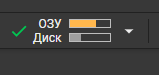


Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

# Описание решения (!)

1. Нанесение чёрных квадратов выполнено в разделе *Подготовка входных данных* с помощью функции apply_square().
2. В разделе *Создание и обучение автокодировщика* находятся два варианта решения задачи:
> - модель со скрытым пространством на Dense слое - на ней получена MSE 0.0036 на тестовой выборке;
> - модель с использованием только свёрточных слоёв - на ней получена MSE 0.0027 на тестовой выборке.
3. В разделе *Проверка результата* для каждой модели приведена рандомная выборка восстановленных изображений из тестовой выборки. Выглядит неплохо и даже магически :)
4. Несмотря на то, что с моделью на Dense-слое получен хороший результат, она явно уступает модели на свёрточных слоях, т.к. имеет в 20 раз больше тренируемых параметров и медленнее обучается, чем последняя.
5. При построении автокодировщика раздельно созданы модели кодировщика и декодировщика, которые затем объединены.
6. Для ускорения обучения - оно стартует с шагом 0.001 и далее используется callback с ручной настройкой, понижающий шаг обучения.


# Подготовка


## Импорт библиотек

In [1]:
import numpy as np 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils

import matplotlib.pyplot as plt
import seaborn as sns

import os, gdown, glob, time, copy, gc

%matplotlib inline

## Загрузка датасета

In [ ]:
SOURCE_FILE = 'construction_256x192.zip'
# SOURCE_FILE = 'construction_512x384.zip'
DATA_DIR = './construction'

# загрузим данные, если нет папки с распакованным архивом
if not os.path.exists(DATA_DIR):

    # загрузим архив, если его нет на диске
    if not os.path.exists(SOURCE_FILE):
        gdown.download(f'https://storage.yandexcloud.net/aiueducation/Content/base/l14/{SOURCE_FILE}', None, quiet=True)

    # распаковка архива на локальный диск colab
    !mkdir {DATA_DIR[2:]}
    !unzip -qo {SOURCE_FILE} -d {DATA_DIR}

# Сервисные классы и функции

### ProgressBar - класс для вывода индикатора выполнения

In [ ]:
# выводит прогресс-бар
# event_index - текущее значение (начало отсчёта - 0)
# events_count - всего значений
# msg - сообщение, выводимое в строке следом за индикатором
# bar_width - длина индикатора в символах
class ProgressBar():

    def __init__(self, events_count=None, bar_width=20):
        self.events_count = events_count
        self.bar_width = bar_width
        self.started = False

    # выводит начальное состояние индикатора
    def start(self, msg, events_count=None):
        self.started = True
        self.start_time = time.time()
        self.message = msg
        if events_count is not None:
            self.events_count = events_count
        # вывод исходного состояния
        self.update(0)
    
    # обновляет состояние индикатора в соответствии со значением event_index
    def update(self, event_index, msg=None):

        msg = self.message if msg is None else msg

        ready = self.bar_width * event_index // (self.events_count - 1)
        percent = event_index / (self.events_count - 1)
        digits = len(str(self.events_count))
        print(f'\r{percent:>4.0%}|{u"▓" * ready}{u"." * (self.bar_width - ready)}| {event_index + 1:{digits}d}/{self.events_count:{digits}d}: {msg}', end='', flush=True)    

        # последняя итерация
        if event_index >= self.events_count - 1:
            self.started = False
            self.execution_time = time.time() - self.start_time
            # завершим вывод
            print()
            print(f'Время выполнения: {self.execution_time:.1f} сек.')



### Вывод графика метрики модели и ошибки

In [ ]:
# Функция рисует графики обучения модели на одном полотне.
# Параметры:
#   history - объект *.history, возвращаемый методом модели fit()
def draw_history(history, metric=None, start_from_epoch=0):

    # количество выводимых графиков
    n = 1 if metric is None else 2

    sns.set(style='darkgrid', palette='dark') 
    plt.figure(figsize=(6 * n, 4))

    # отрисовка графика метрики
    if metric is not None:
        plt.subplot(1, n, 1)
        plt.plot(history[metric][start_from_epoch:], label='Обучающая выборка')
        plt.plot(history[f'val_{metric}'][start_from_epoch:], label='Проверочная выборка')
        plt.xlabel('Эпоха обучения')
        plt.ylabel(f'{metric}')
        plt.legend()

    # отрисовка графика ошибки
    plt.subplot(1, n, n)
    plt.plot(history['loss'][start_from_epoch:], label='Обучающая выборка')
    plt.plot(history['val_loss'][start_from_epoch:], label='Проверочная выборка')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Ошибка')
    plt.legend()

    print()
    plt.show()

### DataSampling - класс для управления выборками

In [ ]:
class DataSampling:

    # вложенный класс - единичная выборка
    class Sample:

        # инициализация выборки
        def __init__(self, parent, name):
            self.name = name
            # инициализация наборов значений выборки
            for attr in parent.set_names:
                value = copy.deepcopy(parent.init_value)
                setattr(self, attr, value)

    # инициализация экземпляра класса
    # sample_names - названия выборок, используемых в приложении
    # set_names - имена инициализируемых наборов значений
    def __init__(self, sample_names, set_names, data_type, init_value=None):

        self.sample_names = sample_names
        self.set_names = set_names
        self.data_type = data_type
        self.init_value = init_value
        self.sample_count = len(sample_names)

        # инициализация выборок
        for i in range(self.sample_count):
            setattr(self, self.sample_names[i], self.Sample(self, self.sample_names[i]))

    # возвращает заданный набор значений из указанной выборки
    # sample_name - имя выборки
    # set_name - название набора значений
    def get(self, sample_name, set_name):
        return getattr(getattr(self, sample_name), set_name)

    # выводит формы всех наборов данных
    def print_shapes(self):
        if self.data_type == 'numpy':
            for sample_name in self.sample_names:
                print(f'Выборка {sample_name}:')
                for set_name in self.set_names:
                    sample = self.get(sample_name, set_name)
                    if isinstance(sample, np.ndarray):
                        print(f'  Форма набора данных {set_name}: {sample.shape}')
                    else:
                        print(f'  Содержимое набора данных {set_name}: {sample}')
        else:
            raise Exception(f'Вывод формы данных для значений {self.data_type} не предусмотрен.')


### Функции вывода изображений

In [ ]:
# выводит заданное количество случайных или в соответствии
# с переданными индексами изображений 
# data - массив изображений в формате PILImage или numpy
# loc - количество и расположение картинок по вертикали и горизонтали,
#       которое нужно отобразить (y, x)
# cmap - цветовая карта, которая будет применена к одноканальному изображению
# indicies - индексы выводимых изображений
def show_images(data, loc=(3, 7), cmap='viridis', indicies=None):

    fig = plt.figure(figsize=(2 * loc[1], 2 * loc[0]))
    ax = []

    # массивы numpy будем конвертировать в изображения
    do_convert = isinstance(data[0], np.ndarray)

    for i in range(loc[0] * loc[1]):

        if indicies is None:
            # выберем случайную картинку
            img = data[np.random.randint(0, data.shape[0])]
        else:
            img = data[indicies[i]]

        # конвертация
        if do_convert:
            img = utils.array_to_img(img)

        # выведем на полотно
        ax.append(fig.add_subplot(loc[0], loc[1], i + 1))
        ax[i].imshow(img, cmap=cmap)
        ax[i].axis('off')

    # отобразим полотно
    plt.tight_layout()
    plt.show()

In [ ]:
# выводит попарно заданное количество случайных или в соответствии
# с переданными индексами изображений 
# data - объект с выборками из DataSampling в формате PILImage или numpy
# set_names - список с двумя именами наборов данных из DataSampling
# loc - количество и расположение картинок по вертикали и горизонтали,
#       которое нужно отобразить (y, x)
#       количество изображений в ширину будет равно x * 2
# cmap - кортеж из двух цветовых карт, которые будут применены к одноканальным изображениям
# indicies - индексы выводимых изображений
def show_images_pair(data, set_names, loc=(3, 4), cmap=('viridis', 'viridis'), indicies=None):

    fig = plt.figure(figsize=(6 * loc[1], 2 * loc[0]))
    ax = []

    # получим две выборки из данных
    sample = []
    for i in range(2):
        sample.append(getattr(data, set_names[i]))

    # массивы numpy будем конвертировать в изображения
    do_convert = isinstance(sample[0][0], np.ndarray)

    for i in range(loc[0] * loc[1]):

        if indicies is None:
            # выберем случайно парные картинки
            index = np.random.randint(0, sample[0].shape[0])
        else:
            index = indicies[i]
        img = []
        img.append(sample[0][index])
        img.append(sample[1][index])

        # конвертация
        if do_convert:
            img[0] = utils.array_to_img(img[0])
            img[1] = utils.array_to_img(img[1])

        # выведем на полотно
        for axi in range(2):
            ax.append(fig.add_subplot(loc[0], loc[1] * 2, i * 2 + axi + 1))
            # для RGB-изображений параметр cmap игнорируется
            ax[i * 2 + axi].imshow(img[axi], cmap=cmap[axi])
            ax[i * 2 + axi].axis('off')

    # отобразим полотно
    plt.tight_layout()
    plt.show()

### LearningRateScheduler - класс для управления шагом обучения

In [ ]:
def lr_schedule(epoch, lr):
    # Helper function to retrieve the scheduled learning rate based on epoch
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr
    
class LearningRateScheduler(tf.keras.callbacks.Callback):

    def __init__(self, schedule):
        super(LearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('У оптимизатора должен быть атрибут "lr".')

        # получим текущий шаг обучения из оптимизатора
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))

        # получим текущий шаг обучения из графика
        scheduled_lr = self.schedule(epoch, lr)

        # установим оптимизатору текущий шаг обучения
        if epoch == 0 or not np.isclose(lr, scheduled_lr):
            tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
            print(f'\nLearning rate set to {scheduled_lr}:')   

### HyperParameters - класс для удобной работы с гиперпараметрами

In [ ]:
class HyperParameters():

    def __init__(self):
        self.groups = dict()
        # параметры, по которым выводится описание
        self.known_keys = {
            'frame_length': 'длина текстовой последовательности',
            'frame_step': 'сдвиг окна при формировании текстовых последовательностей',
            'source_voc_size': 'размер общего словаря, извлекаемого из текста изначально',
            'voc_size': 'размер словаря для текущей модели',
            'ngrams': 'размер Ngram, на которые разбивается текст, либо None',
            'vectorize_mode': 'выходной формат слоя векторизации (int, multi_hot)',
            'train_size_ratio': 'доля обучающей выборки',
            'valid_size_ratio': 'доля проверочной выборки',
            'batch_size': 'размер батча',
            'learning_rate': 'шаг обучения',
            'epochs': 'количество эпох обучения',
            'embeddings_dim': 'размерность эмбеддингов',
            'optimizer': 'оптимизатор',
            'loss_fn': 'функция потерь'
        }

    # возвращает длину значения
    # если у значения есть атрибут name, то возвращается его длина
    def _get_value_length(self, attr):

        value = getattr(self, attr)

        # print(f':: value: {value}')

        if getattr(value, 'name', None) is not None:
            # print(f'>> {getattr(value, "name")}')
            return len(getattr(value, 'name'))
        else:
            return len(str(value))

    # формирует название гиперпараметра для печати
    def _format(self, attr, max_len):

        value = getattr(self, attr)
        
        # пока не будем печатать списки в параметрах
        if isinstance(value, list):
            value = 'list'

        # если у значения есть атрибут name, то возьмём его
        if getattr(value, 'name', None) is not None:
            p_value = getattr(value, 'name')
        else:
            p_value = str(value)

        output = f'{attr:<{max_len["param"]}}  {p_value:>{max_len["value"]}}'
        if attr in self.known_keys:
            output += f'  # {self.known_keys[attr]}'

        return output

    # запоминает в объекте переданные гиперпараметры
    def set(self, group='default', **kwargs):
        for key, value in kwargs.items():

            setattr(self, key, value)
            # добавим группу параметров, если она ещё не определена
            if group not in self.groups.keys():
                self.groups[group] = []

            # проверим уникальность параметра общем наборе
            # (если он есть, то переданная группа должна совпадать)
            for group_name, group_keys in self.groups.items():
                if key in group_keys and group != group_name:
                    raise ValueError(f'Key "{key}" must be unique in instance '
                    + f'of {self.__class__.__name__}. But found already exists in group "{group_name}".')

            # добавим параметр в группу, если его не существует
            if key not in self.groups[group]:
                self.groups[group] += [key]

    # выводит все гиперпараметры
    def print(self, *args, by_groups=True):

        exclude_list = ['known_keys', 'groups']

        # посчитаем максимальную длину строки: параметр + значение,
        # чтобы сделать красивый вывод
        max_len = {'param': 0, 'value': 0}
        for attr in self.__dict__:
            if attr not in exclude_list:
                len_param = len(attr)
                len_value = self._get_value_length(attr)
                if len_param > max_len['param']:
                    max_len['param'] = len_param
                if len_value > max_len['value']:
                    max_len['value'] = len_value

        print('\nГИПЕРПАРАМЕТРЫ')

        # если передан список групп
        if len(args) > 0:
            for group in args:
                if group not in self.groups.keys():
                    raise ValueError(f'Group "{group}"" is not found within groups in instance of {self.__class__.__name__}.')
                print(' ', f'{group}:')
                for key in self.groups[group]:
                    print(' '*3, f'{self._format(key, max_len)}')
        else:
            for group in self.groups.keys():
                if by_groups:
                    print(' ', f'{group}:')
                indent = ' '*4 if by_groups else ' '*2
                for key in self.groups[group]:
                    print(f'{indent}{self._format(key, max_len)}')

### train_model - функция компиляции и обучения модели

In [ ]:
# функция компиляции и обучения модели
def train_model(model, hp, data, sample_names, set_names):

    # оптимизатор
    if hp.optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam()
    elif hp.optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop()

    # компиляция
    model.compile(optimizer=optimizer, loss=hp.loss_fn, metrics=hp.metrics)

    # укажем директорию и именование файлов для TensorBoard (из текущей даты)
    # logdir = os.path.join("logs", get_str_date())

    # сформируем callback для TensorBoard
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(
    #     logdir,
    #     histogram_freq=1,
    #     update_freq="epoch"
    #     )

    if data.data_type == 'numpy':
        batch_size = hp.batch_size
        # первая переданная выборка - тренировочная
        x_train = data.get(sample_names[0], set_names[0]),
        y_train = data.get(sample_names[0], set_names[1]),
        # вторая переданная выборка - проверочная
        validation_data = (
            data.get(sample_names[1], set_names[0]),
            data.get(sample_names[1], set_names[1])
        )
    else:
        batch_size = None
        y_train = None
        y_valid = None
        raise Exception('Для значений data_type кроме "numpy" функция на настроена.')

    # обучение
    record = model.fit(
                    x_train, y_train,
                    epochs=hp.epochs,            
                    batch_size=batch_size,
                    validation_data=validation_data,
                    callbacks=[
                        # tensorboard_callback,
                        LearningRateScheduler(lr_schedule),
                        ]
                    )
    return record, model  

# Загрузка и подготовка данных

## Подготовка выборок, загрузка и просмотр изображений

hp = Hyper

In [ ]:
hp = HyperParameters()
hp.set('DATA',
    # высота изображения
    img_height = 192,
    # ширина изображения
    img_width=256,
    # class_count=None
    )

In [ ]:
# инициализируем объект для хранения двух выборок (тренировочной и тестовой)
# и наборов значений в них
dt = DataSampling(
    # имена выборок
    sample_names=['train', 'val'],
    # имена всех наборов значений, которые понадобятся
    set_names=['original', 'segment', 'reclassed', 'predict'],
    # тип данных в выборке на этапе обучения
    data_type='numpy',
    # исходное значение для инициализации выборок
    init_value = []
    )

# проверим что атрибуты для хранения выборок созданы
for sample_name in dt.sample_names:    
    sample = getattr(dt, sample_name)
    print(f'Выборка "{sample_name}" ({sample}):')
    for set_name in dt.set_names:
        print(f'  {set_name}: {getattr(sample, set_name)}')

In [ ]:
# инициализируем индикатор выполнения
progress_bar = ProgressBar()

# считаем изображения для каждой из выборок
for sample_name in dt.sample_names:

    # зададим директории для оригинальных и сегментированных файлов
    dir_original = f'{DATA_DIR}/{sample_name}/{dt.set_names[0]}'
    dir_segment = f'{DATA_DIR}/{sample_name}/{dt.set_names[1]}'

    # список файлов в директории
    file_list = glob.glob(f'{dir_original}/*.bmp')
    
    # текущая выборка
    sample = getattr(dt, sample_name)

    # зададим начальное состояние индикатора выполнения
    progress_bar.start(msg=f'чтение изображений выборки {sample_name}', \
        events_count=len(file_list))

    # попарно считаем все оригинальные и сегментированные изображения
    # и сконвертируем их в numpy-массивы
    for i in range(len(file_list)):

        # прочитаем оригинальное изображения
        original_name = file_list[i]
        sample.original.append(
            utils.img_to_array(
                utils.load_img(
                    original_name,
                    target_size=(hp.img_height, hp.img_width)
                )
            )
        )
        # прочитаем соответствующее сегментированное изображение
        segment_file = original_name.replace(dt.set_names[0], dt.set_names[1])
        sample.segment.append(
            utils.img_to_array(
                utils.load_img(
                    segment_file,
                    target_size=(hp.img_height, hp.img_width)
                )
            )
        )
        # отобразим ход выполнения
        progress_bar.update(i)

In [ ]:
# преобразуем выборки в массивы numpy
for sample_name in dt.sample_names:
    # текущая выборка
    sample = getattr(dt, sample_name)

    sample.original = np.array(sample.original)
    sample.segment = np.array(sample.segment)
    # значения для реклассификации инициализируем нулями
    sample.reclassed = np.zeros(
        (sample.original.shape[0], hp.img_height, hp.img_width, 1), 
        dtype='uint8'
        )

In [ ]:
# проверим формы выборок
dt.print_shapes()

In [ ]:
# посмотрим несколько пар изображений тренировочной выборки
show_images_pair(dt.train, ['original', 'segment'], loc=(4, 3))

## Создание нового классификатора

In [ ]:
# цвета пикселей сегментированных изображений
FLOOR = (100, 100, 100)         # Пол (серый)
CEILING = (0, 0, 100)           # Потолок (синий)
WALL = (0, 100, 0)              # Стена (зеленый)
COLUMN = (100, 0, 0)            # Колонна (красный)
APERTURE = (0, 100, 100)        # Проем (темно-бирюзовый)
DOOR = (100, 0, 100)            # Дверь (бордовый)
WINDOW = (100, 100, 0)          # Окно (золотой)
EXTERNAL = (200, 200, 200)      # Внешний мир (светло-серый)
RAILINGS = (0, 200, 0)          # Перила (светло-зеленый)
BATTERY = (200, 0, 0)           # Батареи (светло-красный)
PEOPLE = (0, 200, 200)          # Люди (бирюзовый)
LADDER = (0, 0, 200)            # Лестница (светло-синий)
INVENTORY = (200, 0, 200)       # Инвентарь (розовый)
LAMP = (200, 200, 0)            # Лампа (желтый)
WIRE = (0, 100, 200)            # Провод (голубой)
BEAM = (100, 0, 200)            # Балка (фиолетовый)
# общий кортеж меток
CLASS_LABELS = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, \
    EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

In [ ]:
# новые метки классов в соответствии с заданием
NEW_CLASSES = {
    FLOOR: 0,
    CEILING: 1,
    WALL: 2,
    APERTURE: 3, DOOR: 3, WINDOW: 3,
    COLUMN: 4, RAILINGS: 4, LADDER: 4,
    INVENTORY: 5,
    LAMP: 6, WIRE: 6, BEAM: 6, EXTERNAL: 6, BATTERY: 6, PEOPLE: 6
}
CLASS_COUNT = len(set(NEW_CLASSES.values()))

In [ ]:
# проверим, как установлено соответствие классов
for i, class_color in enumerate(CLASS_LABELS):
    print(f'{i:<2} {str(class_color):<17} {NEW_CLASSES.get(class_color)}')

## Реклассификация и анализ распределения классов

In [ ]:
# зададим начальное состояние индикатора выполнения
progress_bar.start(msg=f'реклассификация сегментированных изображений', \
    events_count=len(CLASS_LABELS))

# классифицируем сегменты в соответствии с заданием
for i, class_color in enumerate(CLASS_LABELS):

    cl = NEW_CLASSES.get(class_color)

    dt.train.reclassed[np.all(dt.train.segment == class_color, axis=-1)] = cl
    dt.val.reclassed[np.all(dt.val.segment == class_color, axis=-1)] = cl
    
    progress_bar.update(i)
    # gc.collect()

In [ ]:
print(f'Форма реклассифицированной выборки: {dt.train.reclassed.shape}')

In [ ]:
# вычисление количества пикселов по всем классам в y_train
pix_count = np.zeros(CLASS_COUNT)
for i in range(CLASS_COUNT):
    pix_count[i] = (dt.train.reclassed == i).sum()

# посмотрим на распределение классов
plt.figure(figsize = (4, 3))
plt.bar(np.arange(CLASS_COUNT), pix_count)
plt.show()

## Просмотр сегментированных исходных и реклассифицированных изображений

In [ ]:
# посмотрим несколько пар сегментированных и реклассифицированных изображений
show_images_pair(dt.train, ['segment', 'reclassed'], loc=(4, 3)) 

# Создание и обучение модели

## Создание и обучение модели

In [ ]:
model = None
dt.val.predict = None
gc.collect()


ГИПЕРПАРАМЕТРЫ
  DATA:
    img_height                              192
    img_width                               256
  MODEL:
    epochs                                    8  # количество эпох обучения
    loss_fn                                 SCC  # функция потерь
    optimizer                              adam  # оптимизатор
    metrics                                list
    input_dim                     (192, 256, 3)
    batch_size                               16  # размер батча

Model: "PSPNet"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 original_img (InputLayer)             [(None, 192, 256, 3)]      0             []                                      
                                                                                                                        
 tf.c

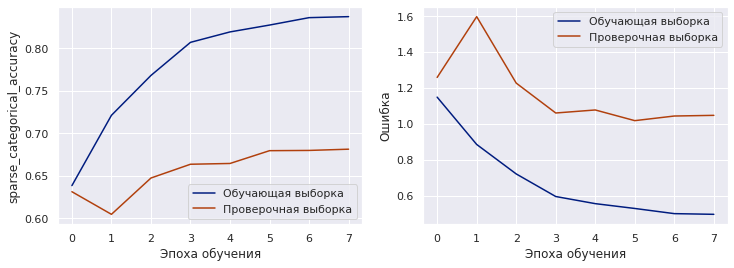

In [38]:
# гиперпараметры модели
# hp = HyperParameters()
hp.set('MODEL',
    epochs=8,
    # функция ошибки
    loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        reduction="auto",
        name="SCC",
    ),
    # выбор оптимизатора
    optimizer=['adam', 'rmsprop', 'nadam'][0],
    # метрики
    metrics=['sparse_categorical_accuracy'],
    # форма входа модели
    input_dim=dt.train.original[0].shape,   
    # размер батча 
    batch_size=16
    )
hp.print()

# график изменения шага обучения при наступлении заданной эпохи обучения
# (epoch, learning_rate)
LR_SCHEDULE = [
    (0, 0.01),
    (2, 0.001),
    (6, 0.0001),
    # (6, 0.00001),
    ]

# построение модели PSPNet
def build_model(hp):

    # вход
    input = keras.Input(shape=hp.input_dim, name="original_img")

    # карта признаков

    if False:
        x = layers.Conv2D(128, 3, padding='same', activation="relu", name='c-m1')(input)
    else:
        # нормируем изображения к диапазону [-1:1]
        x = tf.cast(input, tf.float32)
        x = tf.keras.applications.resnet_v2.preprocess_input(x)

        # используем для формирования карты признаков модель ResNet101V2
        core = tf.keras.applications.ResNet101V2( # выход: (None, 6, 8, 2048)
            include_top=False,
            weights="imagenet",
            input_shape=hp.input_dim
        )
        # заморозим веса базовой модели
        core.trainable = False
        # базовая модель в режиме инференса
        x = core(x, training=False)

        # развернём признаки до формы исходного изображения 192х256х3
        x = layers.Conv2DTranspose(1024, 3, strides=2, padding='same', activation="relu", name="ct-m1")(x)
        x = layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation="relu", name="ct-m2")(x)
        x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation="relu", name="ct-m3")(x)
        x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation="relu", name="ct-m4")(x)
        x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation="relu", name="ct-m5")(x)
        x = layers.BatchNormalization(name="bn-m1")(x)

    # Pyramid-блоки
    
    units = 64

    # pooling = 1
    x0 = x
    x0 = layers.Conv2D(units, 3, padding='same', activation="relu", name="c-p0")(x0)
    x0 = layers.Conv2DTranspose(units, 3, padding='same', activation="relu", name="ct-p0")(x0)

    # pooling = 2
    x1 = layers.MaxPooling2D(2, name="mp-p1")(x)
    x1 = layers.Conv2D(units, 3, padding='same', activation="relu", name="c-p1")(x1)
    x1 = layers.Conv2DTranspose(units, 3, strides=2, padding='same', activation="relu", name="ct-p1")(x1)

    # pooling = (3, 4)
    x1 = layers.MaxPooling2D((3, 4), name="mp-p1")(x)
    x1 = layers.Conv2D(units, 3, padding='same', activation="relu", name="c-p1")(x1)
    x1 = layers.Conv2DTranspose(units, 3, strides=(3, 4), padding='same', activation="relu", name="ct-p1")(x1)

    # pooling = 4
    x2 = layers.MaxPooling2D(4, name="mp-p2")(x)
    x2 = layers.Conv2D(units, 3, padding='same', activation="relu", name="c-p2")(x2)
    x2 = layers.Conv2DTranspose(units, 3, strides=4, padding='same', activation="relu", name="ct-p2")(x2)

    # pooling = (6, 8)
    x3 = layers.MaxPooling2D((6, 8), name="mp-p3")(x) # (28, 32)
    x3 = layers.Conv2D(units, 3, padding='same', activation="relu", name="c-p3")(x3) # (28, 42)
    x3 = layers.Conv2DTranspose(units, 3, strides=(6, 8), padding='same', activation="relu", name="ct-p3")(x3)

    # pooling = 8
    x4 = layers.MaxPooling2D((8, 8), name="mp-p4")(x) # (24, 32)
    x4 = layers.Conv2D(units, 3, padding='same', activation="relu", name="c-p4")(x4) # (28, 42)
    x4 = layers.Conv2DTranspose(units, 3, strides=(8, 8), padding='same', activation="relu", name="ct-p4")(x4)

    x = layers.concatenate([input, x0, x1, x2, x3, x4], name="concat")

    # финальная свёртка

    x = layers.Conv2D(64, 3, padding='same', activation="relu", name="c-f1")(x)
    x = layers.Conv2D(64, 3, padding='same', activation="relu", name="c-f2")(x)
    x = layers.BatchNormalization(name="bn-f1")(x)
    
    # выходной классификатор
    x_out = layers.Conv2D(CLASS_COUNT, 3, padding='same', activation="softmax", name="c-out1")(x)

    pspnet = keras.Model(input, x_out, name="PSPNet")
    print()
    pspnet.summary(line_length=120)

    return pspnet

# создадим модель
model = build_model(hp)

# запустим функциию компиляции обучения модели, передав ей подготовленные даннные и
# указав какие выборки и наборы значений использовать
record, model = train_model(model, hp, dt,
    sample_names=['train', 'val'], 
    set_names=['original', 'reclassed'])

# выведем графики ошибки
draw_history(record.history, metric=hp.metrics[0], start_from_epoch=0)    

## Дообучение

In [ ]:
gc.collect()

39667


Learning rate set to 1e-05:
Epoch 1/5
60/60 [==============================] - 54s 887ms/step - loss: 1.3097 - sparse_categorical_accuracy: 0.5973 - val_loss: 1.5090 - val_sparse_categorical_accuracy: 0.4984
Epoch 2/5
60/60 [==============================] - 52s 874ms/step - loss: 1.3005 - sparse_categorical_accuracy: 0.5987 - val_loss: 1.5686 - val_sparse_categorical_accuracy: 0.4792
Epoch 3/5
60/60 [==============================] - 53s 878ms/step - loss: 1.2936 - sparse_categorical_accuracy: 0.5996 - val_loss: 1.4894 - val_sparse_categorical_accuracy: 0.5028
Epoch 4/5
60/60 [==============================] - 53s 876ms/step - loss: 1.2845 - sparse_categorical_accuracy: 0.6013 - val_loss: 1.4893 - val_sparse_categorical_accuracy: 0.5029
Epoch 5/5
60/60 [==============================] - 53s 877ms/step - loss: 1.2781 - sparse_categorical_accuracy: 0.6025 - val_loss: 1.5048 - val_sparse_categorical_accuracy: 0.4963



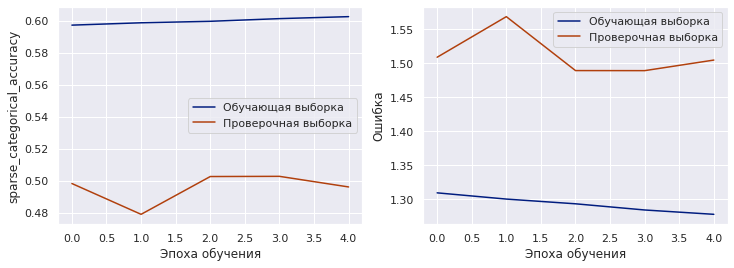

In [ ]:
# дообучение
hp.epochs = 5
LR_SCHEDULE = [
    (0, 0.00001),
    ]

record, model = train_model(model, hp, dt,
    sample_names=['train', 'val'], 
    set_names=['original', 'reclassed'])

# выведем графики ошибки
draw_history(record.history, metric=hp.metrics[0], start_from_epoch=0)  

## Проверка результата

In [ ]:
dt.print_shapes()

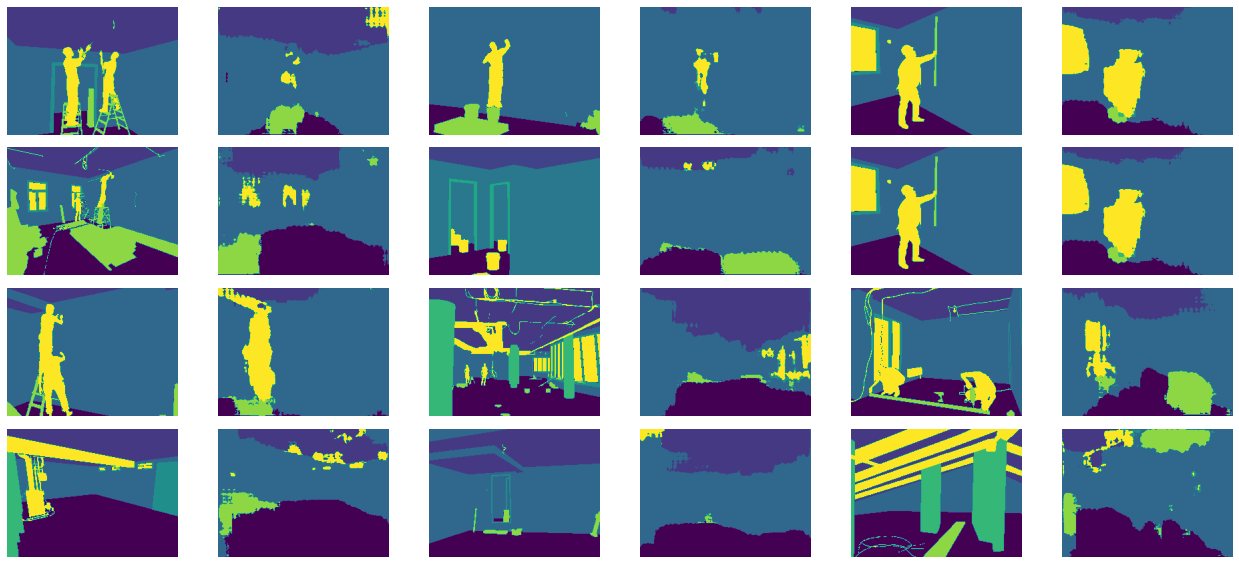

In [39]:
# выполним предсказание по проверочной выборке 
# и сравним результат с реклассифицированными изображениями
dt.val.predict = np.expand_dims(
    np.argmax(
        model.predict(dt.val.original), 
        axis=-1
        ), 
    axis=-1
    )
show_images_pair(dt.val, ['reclassed', 'predict'], loc=(4, 3))

In [48]:
def e(pair):
    return model.evaluate(pair[0], pair[1], verbose=0)

ve = np.vectorize(e)

In [49]:
print(ve)

In [ ]:
pair = np.vstack([dt.val.original, dt.val.reclassed])

In [ ]:
np.apply_along_axis(ve, axis=0, arr)

In [ ]:
list(map(e((dt.val.original, dt.val.reclassed))))[:5]

In [56]:
# получение массива значений функции ошибки для каждого изображения из проверочной выборки
accuracy = np.array(
    [model.evaluate(
        dt.val.original[i: i + 1], 
        dt.val.reclassed[i: i + 1],
        verbose=0)[1] 
        for i in range(dt.val.original.shape[0])
        ])

print(accuracy[:10])

[0.75559491 0.4773356  0.57560223 0.76654053 0.66577148 0.78932697
 0.78672284 0.44291177 0.79484051 0.65016681]


In [65]:
# получение индексов самых плохих по точности сегментации изображений
# print('5 худших по точности сегментации изображений')
worst = np.argsort(accuracy)[:9].tolist()
best = np.argsort(accuracy)[-9:].tolist()

# for b in bad:
#     print(f'Изображение №{b} - точность: {accuracy[b]}')


Изображения с наихудшей точностью классификации:



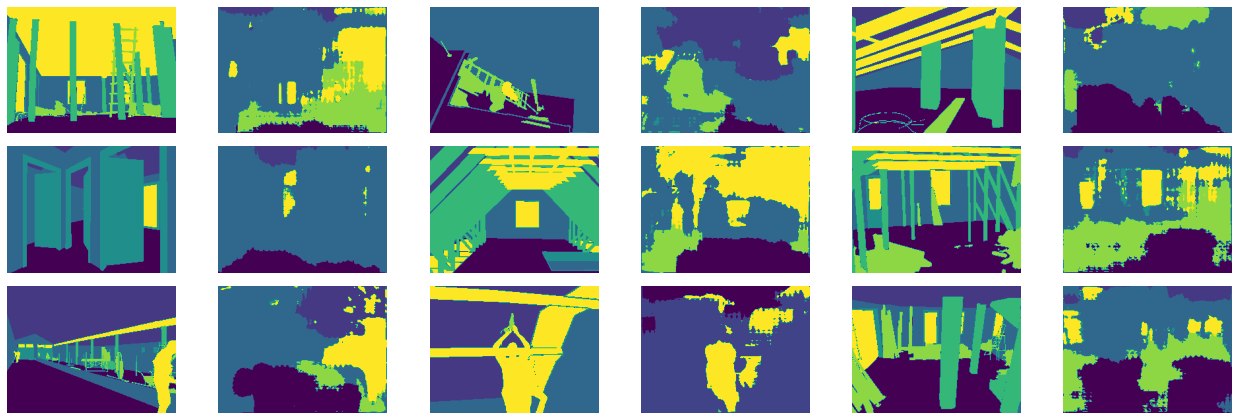


Изображения с наилучшей точностью классификации:



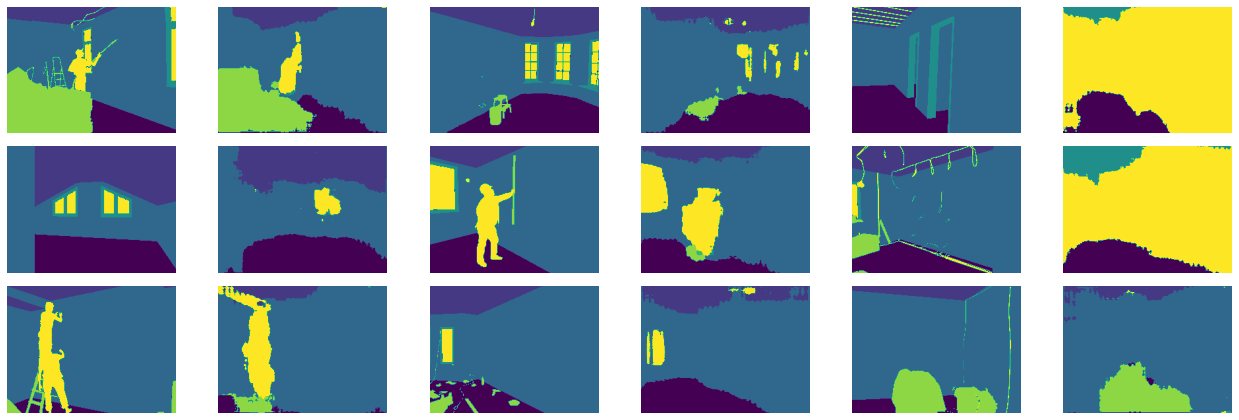

In [66]:
print(f'\nИзображения с наихудшей точностью классификации:\n')
show_images_pair(dt.val, ['reclassed', 'predict'], loc=(3, 3), indicies=worst)
print(f'\nИзображения с наилучшей точностью классификации:\n')
show_images_pair(dt.val, ['reclassed', 'predict'], loc=(3, 3), indicies=best)

# Эксперименты

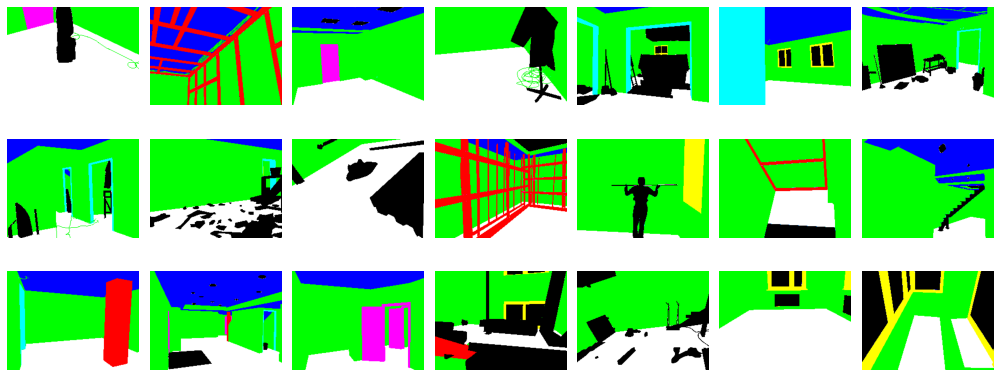

In [ ]:
# проверка конвертации цвета: заменим светло-серый на чёрный
imgs = dt.train.segment
imgs = np.where(imgs == (200, 200, 200), (0, 0, 0), imgs)
show_images(imgs, loc=(3, 7))

In [ ]:
# import scipy.misc
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18,6)

# switch activation from softmax to linear
# visualize final layer output as an image and not class
model.layers[-1].activation = activations.linearmodel = utils.apply_modifications(model)

# Black Bear-295th index of the ImageNet dataset
img1 = visualize_activation(model,-1,\
           filter_indices=295,\
           max_iter=5000,\
           verbose=True)

# Polar Bear-296th index of the ImageNet dataset
img2 = visualize_activation(model,-1,\
           filter_indices=296,\
           max_iter=5000,\
           verbose=True)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(img1)
ax2.imshow(img2)